In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, Concatenate, Multiply, Layer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import cv2
import os

In [2]:
# Function to preprocess TIFF images
def preprocess_tiff(image_path, target_size, bands=[4, 3, 2], normalize=False):
    with rasterio.open(image_path) as src:
        bands_data = [src.read(band) for band in bands]
        rgb_image = np.dstack(bands_data)
        rgb_image = cv2.resize(rgb_image, target_size, interpolation=cv2.INTER_CUBIC)
        if normalize:
            rgb_image = np.clip(rgb_image, 0, 255) / 255.0  # Normalize to 0 to 1
    return rgb_image

# Function to load and preprocess standard images
def load_image(image_path, target_size=(512, 512), normalize=True):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file {image_path} does not exist.")
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"Failed to load image {image_path}.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_CUBIC)
    if normalize:
        image = image / 255.0  # Normalize to 0 to 1
    return image


In [3]:
def split_image(image, size=(256, 256)):
    h, w = image.shape[:2]
    split_images = []
    for i in range(0, h, size[0]):
        for j in range(0, w, size[1]):
            split_img = image[i:i + size[0], j:j + size[1]]
            split_images.append(split_img)
    return split_images

def preprocess_image(hr_file, lr_dir, hr_dir, lc_dir, target_size=(512, 512)):
    hr_image_path = os.path.join(hr_dir, hr_file)
    base_name = hr_file.replace('_rgb.png', '')
    
    hr_image = load_image(hr_image_path, target_size, normalize=True)
    lr_image_file = f"{base_name}-L2A_data.tiff"
    lr_image_path = os.path.join(lr_dir, lr_image_file)
    lr_image = preprocess_tiff(lr_image_path, target_size, normalize=True)
    
    lc_image_file = f"{base_name}.tif"
    lc_image_path = os.path.join(lc_dir, lc_image_file)
    lc_image = preprocess_tiff(lc_image_path, target_size, bands=[1, 2, 3], normalize=True)  # Assuming LC images have RGB bands
    
    hr_splits = split_image(hr_image, (256, 256))
    lr_splits = split_image(lr_image, (256, 256))
    lc_splits = split_image(lc_image, (256, 256))
    
    return hr_splits, lr_splits, lc_splits


In [4]:
def create_dataset(lr_dir, hr_dir, lc_dir, target_size=(512, 512)):
    hr_image_files = [f for f in os.listdir(hr_dir) if f.endswith('_rgb.png') and not f.startswith('.')]
    hr_images = []
    lr_images = []
    lc_images = []

    for hr_file in hr_image_files:
        hr_splits, lr_splits, lc_splits = preprocess_image(hr_file, lr_dir, hr_dir, lc_dir, target_size)
        hr_images.extend(hr_splits)
        lr_images.extend(lr_splits)
        lc_images.extend(lc_splits)

    return np.array(hr_images), np.array(lr_images), np.array(lc_images)


In [5]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(1, 1, input_shape[-1], input_shape[-1]), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(1, 1, 1, input_shape[-1]), initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, inputs):
        attention = K.tanh(K.conv2d(inputs, self.W, strides=(1, 1), padding='same') + self.b)
        attention_weights = K.softmax(attention, axis=-1)
        return attention_weights

def visualize_attention(hr_image, lr_image, lc_image, attention_weights, vmin=0, vmax=1):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(hr_image)
    axs[0].set_title("High-Resolution Image")
    
    # Rescale lr_image and lc_image for visualization
    lr_image_rescaled = (lr_image - np.min(lr_image)) / (np.max(lr_image) - np.min(lr_image))
    lc_image_rescaled = (lc_image - np.min(lc_image)) / (np.max(lc_image) - np.min(lc_image))
    
    axs[1].imshow(lr_image_rescaled)
    axs[1].set_title("Low-Resolution Image")
    
    axs[2].imshow(lc_image_rescaled)
    axs[2].set_title("Land Cover Image")
    
    # Normalize attention weights for visualization
    attention_weights = (attention_weights - np.min(attention_weights)) / (np.max(attention_weights) - np.min(attention_weights))
    axs[3].imshow(attention_weights.squeeze(), cmap='viridis', vmin=vmin, vmax=vmax)
    axs[3].set_title("Attention Map")
    
    for ax in axs:
        ax.axis('off')
    plt.show()


In [6]:
# Paths to directories
hr_dir = 'high_resolution_final'
lr_dir = 'low_resolution_final'
lc_dir = 'land_cover_final'

hr_images, lr_images, lc_images = create_dataset(lr_dir, hr_dir, lc_dir, target_size=(512, 512))


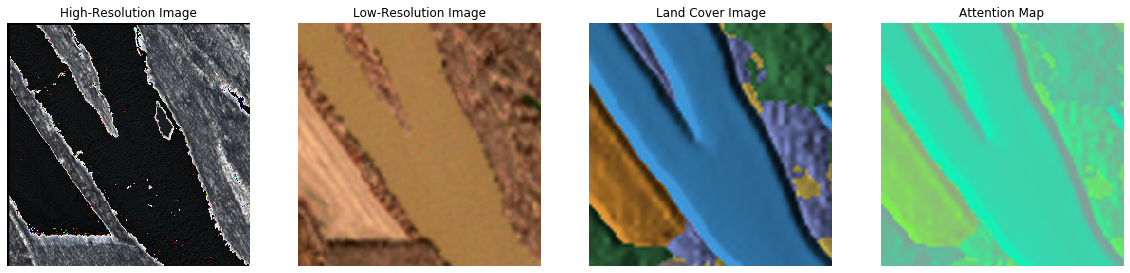

In [9]:
# Select a sample
sample_index = 200
hr_image_sample = hr_images[sample_index]
lr_image_sample = lr_images[sample_index]
lc_image_sample = lc_images[sample_index]

# Normalize for attention computation
lc_image_sample_norm = lc_image_sample

# Expand dimensions to fit the AttentionLayer input
lc_image_sample_expanded = np.expand_dims(lc_image_sample_norm, axis=0)

# Instantiate the AttentionLayer
attention_layer = AttentionLayer()

# Build the layer to initialize weights
attention_layer.build(lc_image_sample_expanded.shape)

# Compute the attention weights
attention_weights = attention_layer(lc_image_sample_expanded)

# Convert tensor to numpy array
attention_weights_np = attention_weights.numpy()

# Visualize the attention with fixed color mapping range
visualize_attention(hr_image_sample, lr_image_sample, lc_image_sample, attention_weights_np, vmin=0, vmax=1)


In [10]:
# Get the size of the numpy arrays in bytes
hr_images_size_bytes = hr_images.nbytes
lr_images_size_bytes = lr_images.nbytes
lc_images_size_bytes = lc_images.nbytes

# Convert sizes to MB for readability
hr_images_size_mb = hr_images_size_bytes / (1024 * 1024)
lr_images_size_mb = lr_images_size_bytes / (1024 * 1024)
lc_images_size_mb = lc_images_size_bytes / (1024 * 1024)

# Convert sizes to GB for readability
hr_images_size_gb = hr_images_size_mb / 1024
lr_images_size_gb = lr_images_size_mb / 1024
lc_images_size_gb = lc_images_size_mb / 1024

print(f"High-resolution images array size: {hr_images_size_gb:.2f} GB")
print(f"Low-resolution images array size: {lr_images_size_gb:.2f} GB")
print(f"Land cover images array size: {lc_images_size_gb:.2f} GB")


High-resolution images array size: 12.66 GB
Low-resolution images array size: 6.33 GB
Land cover images array size: 6.33 GB


In [11]:
# Function to check data
def check_data(hr_images, lr_images, lc_images):
    for i in range(min(4, len(hr_images))):
        hr_image = hr_images[i]
        lr_image = lr_images[i]
        lc_image = lc_images[i]
        
        print(f"High-resolution image {i}: shape={hr_image.shape}, min={hr_image.min()}, max={hr_image.max()}")
        print(f"Low-resolution image {i}: shape={lr_image.shape}, min={lr_image.min()}, max={lr_image.max()}")
        print(f"Land cover image {i}: shape={lc_image.shape}, min={lc_image.min()}, max={lc_image.max()}")
        print("")

# Check data
check_data(hr_images, lr_images, lc_images)


High-resolution image 0: shape=(256, 256, 3), min=0.0, max=0.8862745098039215
Low-resolution image 0: shape=(256, 256, 3), min=0.0004181776021141559, max=0.0016033001011237502
Land cover image 0: shape=(256, 256, 3), min=0.001248774933628738, max=0.0021413627546280622

High-resolution image 1: shape=(256, 256, 3), min=0.0, max=0.9764705882352941
Low-resolution image 1: shape=(256, 256, 3), min=0.00039551325608044863, max=0.0016959129134193063
Land cover image 1: shape=(256, 256, 3), min=0.001263088546693325, max=0.002180150942876935

High-resolution image 2: shape=(256, 256, 3), min=0.0, max=0.8549019607843137
Low-resolution image 2: shape=(256, 256, 3), min=0.0003955548454541713, max=0.001573176239617169
Land cover image 2: shape=(256, 256, 3), min=0.0012607518583536148, max=0.0021709261927753687

High-resolution image 3: shape=(256, 256, 3), min=0.0, max=0.8980392156862745
Low-resolution image 3: shape=(256, 256, 3), min=0.0004150502209085971, max=0.001590272760950029
Land cover imag

In [14]:
# Split the data
train_hr_images, test_hr_images, train_lr_images, test_lr_images, train_lc_images, test_lc_images = train_test_split(
    hr_images, lr_images, lc_images, test_size=0.2, random_state=42)

# Print dataset information
print(f"Training set - HR images: {train_hr_images.shape}, LR images: {train_lr_images.shape}, LC images: {train_lc_images.shape}")
print(f"Test set - HR images: {test_hr_images.shape}, LR images: {test_lr_images.shape}, LC images: {test_lc_images.shape}")


Training set - HR images: (6912, 256, 256, 3), LR images: (6912, 256, 256, 3), LC images: (6912, 256, 256, 3)
Test set - HR images: (1728, 256, 256, 3), LR images: (1728, 256, 256, 3), LC images: (1728, 256, 256, 3)


In [17]:
# Generator class for training data
class DataGenerator(Sequence):
    def __init__(self, lr_images, hr_images, lc_images, batch_size=64, target_size=(512, 512)):
        self.lr_images = lr_images
        self.hr_images = hr_images
        self.lc_images = lc_images
        self.batch_size = batch_size
        self.target_size = target_size
        self.indices = np.arange(len(self.lr_images))
        
    def __len__(self):
        return int(np.floor(len(self.lr_images) / self.batch_size))
    
    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        lr_batch = np.array([self.lr_images[i] for i in indices])
        hr_batch = np.array([self.hr_images[i] for i in indices])
        lc_batch = np.array([self.lc_images[i] for i in indices])
        return [lr_batch, lc_batch], hr_batch

    def on_epoch_end(self):
        np.random.shuffle(self.indices)
    
    def get_info(self):
        info = {
            'num_samples': len(self.lr_images),
            'batch_size': self.batch_size,
            'num_batches': self.__len__(),
            'image_shape': self.lr_images[0].shape if len(self.lr_images) > 0 else None,
        }
        return info

# Create data generators
train_generator = DataGenerator(train_lr_images, train_hr_images, train_lc_images, batch_size=64)
test_generator = DataGenerator(test_lr_images, test_hr_images, test_lc_images, batch_size=64)


In [18]:
# Define PSNR and SSIM metrics
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def create_model_with_attention(input_shape=(256, 256, 3)):
    lr_input = Input(shape=input_shape, name='lr_input')
    lc_input = Input(shape=input_shape, name='lc_input')

    attention = AttentionLayer()(lc_input)
    weighted_lr = Multiply()([lr_input, attention])

    concat_inputs = Concatenate()([weighted_lr, lc_input])
    
    x = Conv2D(64, (9, 9), activation='relu', padding='same')(concat_inputs)
    x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
    outputs = Conv2D(3, (5, 5), activation='linear', padding='same')(x)
    
    model = Model(inputs=[lr_input, lc_input], outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', psnr_metric, ssim_metric])
    return model

model = create_model_with_attention()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lc_input (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lr_input (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 attention_layer_2 (AttentionLa  (None, 256, 256, 3)  12         ['lc_input[0][0]']               
 yer)                                                                                         

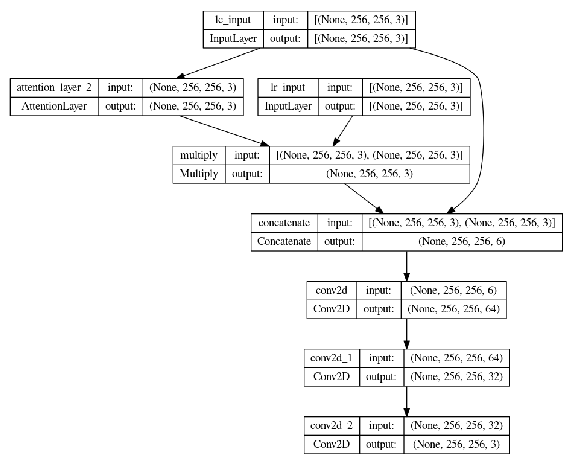

In [19]:
from tensorflow.keras.utils import plot_model

# Plot model
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

# Display the model plot
img = plt.imread('model_structure.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()


In [20]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_with_attention.h5', save_best_only=True, monitor='val_loss')


In [ ]:
# Train the model
history = model.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
loss, accuracy, psnr, ssim = model.evaluate(test_generator)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}, Test PSNR: {psnr}, Test SSIM: {ssim}")

# Save the final model
model.save('srcnn_with_attention_final.h5')

Epoch 1/20
108/108 [==============================] - 2730s 25s/step - loss: 0.0238 - accuracy: 0.6152 - psnr_metric: 19.3054 - ssim_metric: 0.4241 - val_loss: 0.0217 - val_accuracy: 0.6149 - val_psnr_metric: 19.8369 - val_ssim_metric: 0.4541
Epoch 2/20
108/108 [==============================] - 2698s 25s/step - loss: 0.0188 - accuracy: 0.6192 - psnr_metric: 20.0149 - ssim_metric: 0.4607 - val_loss: 0.0197 - val_accuracy: 0.6199 - val_psnr_metric: 20.2931 - val_ssim_metric: 0.4736
Epoch 3/20
108/108 [==============================] - 2717s 25s/step - loss: 0.0180 - accuracy: 0.6488 - psnr_metric: 20.3901 - ssim_metric: 0.4744 - val_loss: 0.0184 - val_accuracy: 0.6321 - val_psnr_metric: 20.7401 - val_ssim_metric: 0.4860
Epoch 4/20
108/108 [==============================] - 2836s 26s/step - loss: 0.0159 - accuracy: 0.6669 - psnr_metric: 20.9103 - ssim_metric: 0.4916 - val_loss: 0.0165 - val_accuracy: 0.6927 - val_psnr_metric: 20.9388 - val_ssim_metric: 0.4949
Epoch 5/20
108/108 [========